Skin lesion segmentation

Delineate lesion boundary in skin images
Dataset - https://www.isic-archive.com/#!/topWithHeader/tightContentTop/challenges
Understanding how to build deeper networks for image segmentation
Training set = 1000 skin images + label images (binary masks)

Training set
1000 skin images and label map (binary mask)

Convolutional neural networks
Encoder-decoder segmentation network (Fully Convolutional Network)

U-Net: FCN with skip connection

In [ ]:
# opencv 설치
!pip install opencv-python

# 구글드라이브 파일 읽기 위한 연동 용 라이브러리
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)


In [ ]:
# 실질적으로 구글드라이브에서 파일을 불러오는 방법입니다.
# 위에서 준비해두었던 공유 가능한 링크에서 'id=' 이후에 있는 문자열을 복사하여 file_id로 사용합니다.
file_id = '1rya9tkCuzm3F33L9ilT3RtLVUaDQsuOW'
# file_id로부터 파일 객체를 생성합니다.
downloaded = drive.CreateFile({'id': file_id})
# 불러온 파일 객체를 Colab에 저장합니다.
downloaded.GetContentFile('training.zip')
# 압축해제
!unzip training.zip
# 파일 확인
!ls ./testing/image
# 파일 확인
!ls ./testing/labe

Archive:  training.zip
   creating: testing/
   creating: testing/image/
  inflating: testing/image/ISIC_0000000.jpg  
  inflating: testing/image/ISIC_0000001.jpg  
  inflating: testing/image/ISIC_0000003.jpg  
  inflating: testing/image/ISIC_0000004.jpg  
  inflating: testing/image/ISIC_0000006.jpg  
  inflating: testing/image/ISIC_0000007.jpg  
  inflating: testing/image/ISIC_0000008.jpg  
  inflating: testing/image/ISIC_0000009.jpg  
  inflating: testing/image/ISIC_0000011.jpg  
  inflating: testing/image/ISIC_0000012.jpg  
  inflating: testing/image/ISIC_0000013.jpg  
  inflating: testing/image/ISIC_0000014.jpg  
  inflating: testing/image/ISIC_0000015.jpg  
  inflating: testing/image/ISIC_0000016.jpg  
  inflating: testing/image/ISIC_0000017.jpg  
  inflating: testing/image/ISIC_0000018.jpg  
  inflating: testing/image/ISIC_0000019.jpg  
  inflating: testing/image/ISIC_0000020.jpg  
  inflating: testing/image/ISIC_0000021.jpg  
  inflating: testing/image/ISIC_0000022.jpg  
  infla

./training/image/ISIC_0010587.jpg
ISIC_0010587


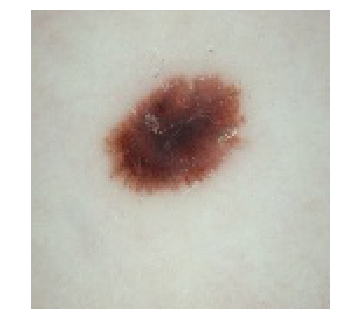

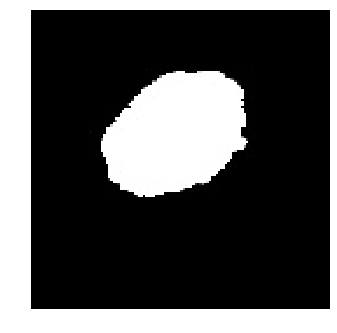

In [ ]:
import os
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


imgDir = './training/image/'
labelDir = './training/label/'

# 트레이닝 영상 리스트 얻기
imgList = glob.glob(imgDir + "/*.jpg")

for f in imgList:
  print(f)
  # 트레이닝 영상으로부터 id 얻기
  id = os.path.basename(f)
  id = os.path.splitext(id)[0]
  print(id)
  
  # label 영상 경로 
  labelF = labelDir + "/" + id + "_segmentation.jpg"  
  
  # 영상 로드
  img = mpimg.imread(f)
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  
  label = mpimg.imread(labelF)
  plt.imshow(label)
  plt.axis("off")
  plt.show()
  
  break


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 32, 32, 32)        0         
__________

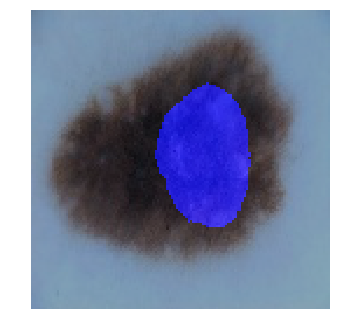

0.9962615
0.0
255.0
0.0


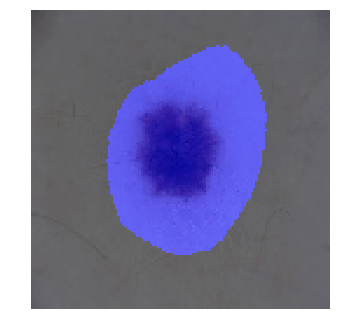

0.99618065
0.0
255.0
0.0


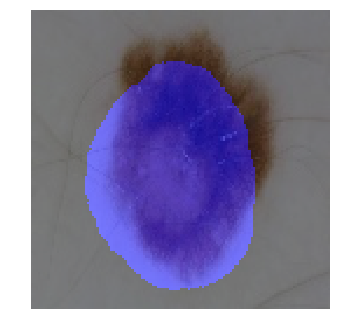

0.99618614
0.0
255.0
0.0


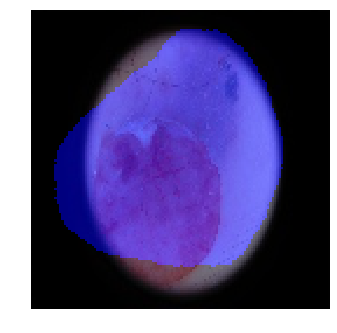

0.996167
0.0
255.0
0.0


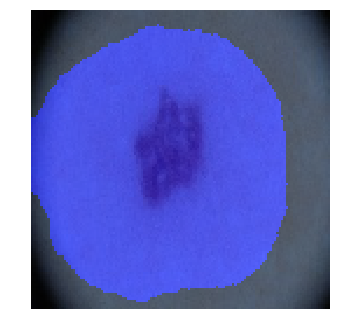

0.99616957
0.0
255.0
0.0


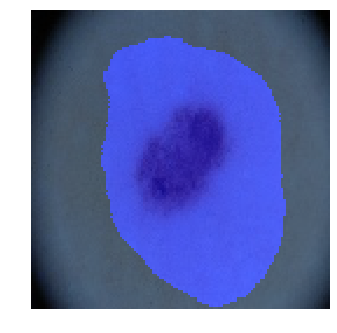

0.9962814
0.0
255.0
0.0


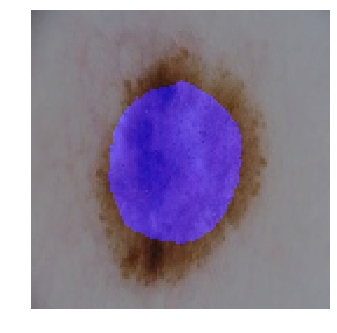

0.996177
0.0
255.0
0.0


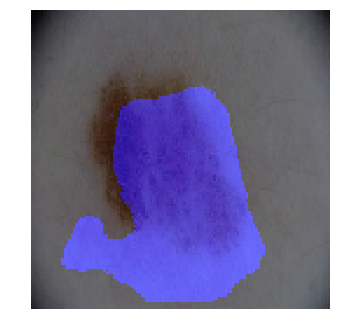

0.9961753
0.0
255.0
0.0


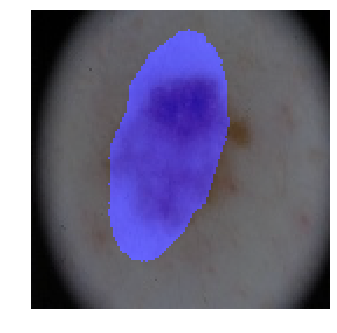

0.99616814
0.0
255.0
0.0


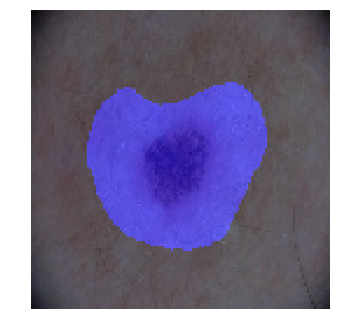

Dice Coefficient
0.5397141583833274


In [ ]:
from keras.callbacks import ModelCheckpoint

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *

import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2

def bce_loss(y_true, y_pred):
    ''' Binary Cross Entropy

    Args:
        y_true (np.array): prediction
        y_pred (np.array): ground-truth
    '''
    return binary_crossentropy(y_true, y_pred)
  
def CNNArch(input_size, lr, depth=1):
    inputs = Input(input_size)

    outLayer = []
    # Encoder
    out = inputs
    base = 16
    for d in range(depth):
      numFeatures = base * (d + 1)
      out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
      out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
      outLayer.append(out)
      out = MaxPooling2D(pool_size=(2, 2))(out)
      
    # bottom layer
    numFeatures = base * (depth + 1)
    out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    
    # Decoder
    for d in range(depth):
        numFeatures = base * (depth - d)
        # Deconvolution (transposed convolution)
        out = Conv2DTranspose(numFeatures, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(out)
#         prev = outLayer[depth-(d+1)]
#         out = concatenate([out, prev], axis=-1)
        # Convolution
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
        out = Conv2D(numFeatures, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    
    out = Conv2D(base, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(out)
    out = Conv2D(1, (1, 1), activation='sigmoid')(out)
    
    # Model 구축
    model = Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=Adam(lr=lr), loss=bce_loss, metrics=[bce_loss])
    model.summary()
    
    return model

# Label to binary
def adjust_data(image, label):
    image = image[0] / 255.0
    image = image[...,::-1]
    # label map 설정 (JPEG 포맷으로 binary mask이지만 정확한 1값이 아닐 수 있음)
    label = label[0][:,:,:,0]
#     print(np.max(label))
    label = np.expand_dims(label, axis=-1)
    label[label < 25] = 0
    label[label >= 25] = 1
    
    
    return image, label
  
# Keras Dataset 함수
def dataset(data_root, mask_root, target_size, batch_size):
    image_datagen = ImageDataGenerator()
    label_datagen = ImageDataGenerator()

    # Dataloader (image)
    image_generator = image_datagen.flow_from_directory(
        data_root,
        classes=['image'],
        target_size = target_size,
        batch_size=batch_size,
        seed=1)

    # Dataloader (label)
    label_generator = label_datagen.flow_from_directory(
        mask_root,
        classes=['label'],
        target_size = target_size,
        batch_size=batch_size,
        seed=1)

    data_generator = zip(image_generator, label_generator)
    for i, (image, label) in enumerate(data_generator):
        image, label = adjust_data(image, label)
        yield (image, label)
        
def save_result(output, data_root, predict_root, gt_root=None):
    img_path = []
    img_path += glob.glob(os.path.join(data_root, 'image/*.jpg'))
    img_path = sorted(img_path)

    label_path = []
    label_path += glob.glob(os.path.join(data_root, 'label/*.jpg'))
    label_path = sorted(label_path)

    output = output.squeeze()
    count = 0
    avgDice = 0
    for i in range(output.shape[0]):
        filename = img_path[i].split('/')[-1]
        predict_path = os.path.join(predict_root, filename)
        gt_path = os.path.join(gt_root, filename)

        img = mpimg.imread(img_path[i])
        label = mpimg.imread(label_path[i])
        target = cv2.imread(label_path[i])

        print(np.max(output[i]))
        print(np.min(output[i]))
        pred = np.round(output[i]) * 255.0 
        print(np.max(pred))
        print(np.min(pred))
        pred = np.expand_dims(pred, axis=2)
        zeros = np.zeros(pred.shape)
        pred = np.concatenate((zeros,zeros,pred), axis=2)
        
        pred = img + pred
        pred = (pred/(pred.max()+1e-6))*255.0
        pred = pred.astype(np.int)
        plt.imshow(pred)
        plt.axis("off")
        plt.show()
        count += 1
        
        #label adjust
        target = target[:,:,0]
        target[target < 25] = 0
        target[target >= 25] = 1
    
        intersect = np.round(output[i])
        intersect = np.count_nonzero(intersect[target==1])
        
        pred = output[i]
        entire = np.count_nonzero(pred[pred == 1]) + np.count_nonzero(label[target==1])        
        
        dice = intersect*2/entire
        avgDice = avgDice + dice
        
        if count == 10:
          print("Dice Coefficient")
          print(avgDice/count)
          break
          
        
        
        
# Main 함수
if __name__ == "__main__":
  # 폴더 설정
  imgDir = './training/'
  labelDir = './training/'
  testImgDir = './testing/'
  testLabelDir = './testing/'
  outDir = './output/'
  
  # 모델 저장 위치
  if (not os.path.exists('./checkpoint')):
    os.mkdir('./checkpoint')
  train_ckpt_path = './checkpoint/unet.hdf5'
  test_ckpt_path = './checkpoint/trained/unet.hdf5'

  if (not os.path.exists(outDir)):
    os.mkdir(outDir)
  # 파라미터 설정
  input_size = (128,128,3)
  
  # Hyperparameters
  epoch = 30
  lr = 0.001
  train_batch_size = 30
  test_batch_size = 30
  depth = 5
  
  # 트레이닝 데이터 셋 설정
  trainingSet = dataset(imgDir, labelDir, (128,128), train_batch_size)
  # 테스트 데이터 셋 설정
  testingSet = dataset(testImgDir, testLabelDir, (128,128),test_batch_size)
  
  # Model 구축
  model = CNNArch(input_size, lr, depth)
  
  # Checkpoint 셋팅
  model_checkpoint = ModelCheckpoint(train_ckpt_path,
                                    monitor='val_loss',
                                    verbose=2,
                                    save_best_only=True)
  # Model Train
  model.fit_generator(trainingSet,
                    steps_per_epoch=800/train_batch_size,
                    shuffle=True,
                    epochs=epoch,
                    validation_data=testingSet,
                    validation_steps=200/test_batch_size,
                    callbacks=[model_checkpoint],
                    workers=1)
  
  # Model Test
  results = model.predict_generator(testingSet,
                                    steps=1,
                                    verbose=1)
  save_result(results, testImgDir, outDir, testImgDir)